In [2]:
import os
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf
from tensorflow.keras import layers, models
from PIL import Image


# Mount Google Drive to access the dataset.
from google.colab import drive
drive.mount('/content/drive')

# -- function for cleaning or removing unsupported image ---
def clean_dataset(directory):
    print("🔍 Cleaning dataset...")
    for root, dirs, files in os.walk(directory):\

        for file in files:
            filepath = os.path.join(root, file)
            try:
                with Image.open(filepath) as img:
                    img.verify()  # Verify image is not corrupted
                    if img.format not in ['JPEG', 'PNG', 'BMP', 'GIF']:
                        raise ValueError(f"Unsupported format: {img.format}")
            except Exception as e:
                print(f"❌ Deleting invalid image: {filepath} ({e})")
                os.remove(filepath)
    print("✅ Dataset cleaning complete.")

# --- Create Custom ResNet Model ---
def create_custom_resnet_model(input_shape=(224, 224, 3), num_classes=2):
    inputs = layers.Input(shape=input_shape)

    # Initial Conv Layer
    x = layers.Conv2D(64, (7, 7), padding='same', strides=(2, 2))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    # ResNet Block
    def resnet_block(x, filters, stride=1):
        shortcut = x
        if stride != 1 or filters * 4 != x.shape[-1]:
            shortcut = layers.Conv2D(filters * 4, (1, 1), strides=stride, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)
        x = layers.Conv2D(filters, (1, 1), strides=stride, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters * 4, (1, 1), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.add([x, shortcut])
        x = layers.Activation('relu')(x)
        return x

    # Residual blocks
    for _ in range(2):
        x = resnet_block(x, 64)
    for _ in range(2):
        x = resnet_block(x, 128, stride=2)
    for _ in range(2):
        x = resnet_block(x, 256, stride=2)
    for _ in range(2):
        x = resnet_block(x, 512, stride=2)

    # Final layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# --- Define Dataset Path and Clean it ---
data_dir = ('/content/drive/MyDrive/Project/DATA SET')
clean_dataset(data_dir)
base_path = '/content/drive/MyDrive/Project'
save_dir = f'{base_path}/saved'
os.makedirs(save_dir, exist_ok=True)



Mounted at /content/drive
🔍 Cleaning dataset...
✅ Dataset cleaning complete.


In [3]:
# ---  Load Data ---

image_size = (224, 224)
batch_size = 16

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")

# ---  Compile and Train Model ---
model = create_custom_resnet_model(num_classes=num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
epochs = 15
try:
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)
except Exception as e:
    print("❌ Error during training:", e)

Found 1320 files belonging to 2 classes.
Using 1056 files for training.
Found 1320 files belonging to 2 classes.
Using 264 files for validation.
Class names: ['CANCER', 'NON CANCER']
Number of classes: 2


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 55, 55,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 55, 55,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 55, 55,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 55, 55,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 55, 55,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 55, 55,    │     16,640 │ activation_2[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 55, 55,    │     16,640 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │      1,024 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 20,565,506 (78.45 MB)

 Trainable params: 20,527,490 (78.31 MB)

 Non-trainable params: 38,016 (148.50 KB)

Epoch 1/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 57s 194ms/step - accuracy: 0.6007 - loss: 1.6893 - val_accuracy: 0.7917 - val_loss: 0.3833
Epoch 2/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - accuracy: 0.7360 - loss: 0.6085 - val_accuracy: 0.0417 - val_loss: 1.2372
Epoch 3/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.8706 - loss: 0.3306 - val_accuracy: 0.3106 - val_loss: 1.0644
Epoch 4/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.9131 - loss: 0.2427 - val_accuracy: 0.8447 - val_loss: 0.4007
Epoch 5/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.9401 - loss: 0.1732 - val_accuracy: 0.9053 - val_loss: 0.2715
Epoch 6/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.9164 - loss: 0.2006 - val_accuracy: 0.5871 - val_loss: 1.9470
Epoch 7/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.9150 - loss: 0.2179 - val_accuracy: 0.9735 - val_loss: 0.0881
Epoch 8/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - accuracy: 0.9653 - loss: 0.1125 - val_accuracy: 0.96

In [4]:
#save model
model.save(f'{save_dir}/res_model3.h5')
print(f"model saved successfully to :{save_dir}/res_model3.h5")



model saved successfully to :/content/drive/MyDrive/Project/saved/res_model3.h5


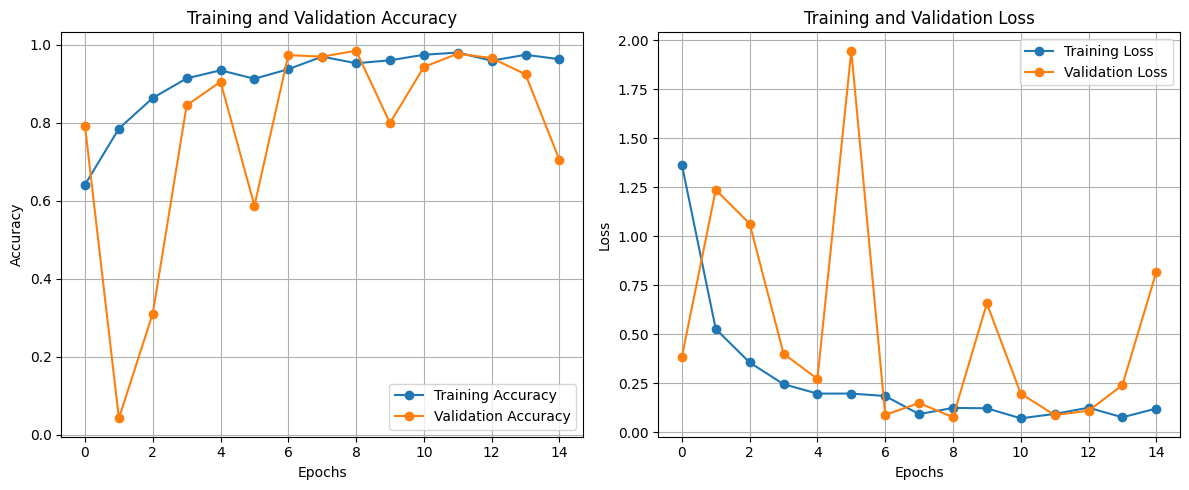

In [5]:
# Retrieve training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs_range = range(len(acc))

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

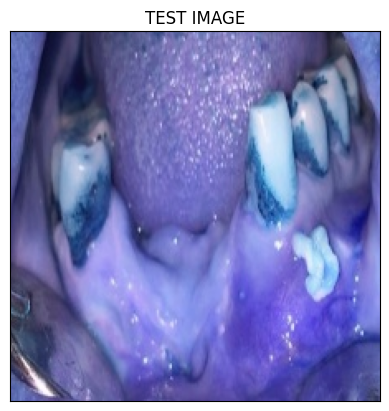

In [6]:
import cv2
import matplotlib.pyplot as plt
image_path='/content/drive/MyDrive/Project/DATA SET/CANCER/CANCER_73.jpg'
img= cv2.imread(image_path)
plt.imshow(img)
plt.title("TEST IMAGE")
plt.xticks([])
plt.yticks([])
plt.show()

In [7]:
import numpy as np
# Load and preprocess the image
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Create a batch

# Normalize the image (important for consistent inference)
#img_array = img_array / 255.0

# Make a prediction using your trained model
predictions = model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


The image is predicted as: CANCER


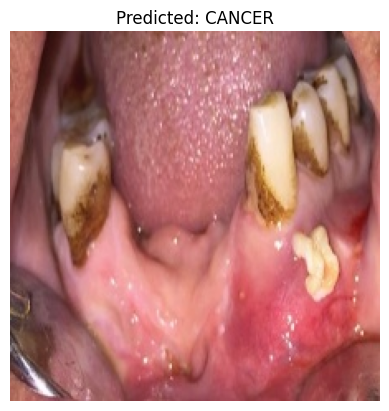

In [8]:
# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Use your class_names to get the predicted class name
predicted_class_name = class_names[predicted_class_index]

# Print the prediction
print(f"The image is predicted as: {predicted_class_name}")

# Optional: Display the image
plt.imshow(img)
plt.title(f"Predicted: {predicted_class_name}")
plt.axis('off')
plt.show()

In [9]:
os.listdir('/content/drive/MyDrive/Project/DATA SET/CANCER')

['CANCER_22.jpg',
 'CANCER_24.jpg',
 'CANCER_26.jpg',
 'CANCER_12.jpg',
 'CANCER_15.jpg',
 'CANCER_20.jpg',
 'CANCER_6.jpg',
 'CANCER_7.jpg',
 'CANCER_11.jpg',
 'CANCER_10.jpg',
 'CANCER_0.jpg',
 'CANCER_23.jpg',
 'CANCER_19.jpg',
 'CANCER_3.jpg',
 'CANCER_8.jpg',
 'CANCER_9.jpg',
 'CANCER_2.jpg',
 'CANCER_25.jpg',
 'CANCER_18.jpg',
 'CANCER_16.jpg',
 'CANCER_14.jpg',
 'CANCER_1.jpg',
 'CANCER_4.jpg',
 'CANCER_28.jpg',
 'CANCER_21.jpg',
 'CANCER_17.jpg',
 'CANCER_13.jpg',
 'CANCER_5.jpg',
 'CANCER_27.jpg',
 'CANCER_94.jpg',
 'CANCER_91.jpg',
 'CANCER_42.jpg',
 'CANCER_95.jpg',
 'CANCER_72.jpg',
 'CANCER_73.jpg',
 'CANCER_55.jpg',
 'CANCER_71.jpg',
 'CANCER_54.jpg',
 'CANCER_38.jpg',
 'CANCER_45.jpg',
 'CANCER_87.jpg',
 'CANCER_90.jpg',
 'CANCER_47.jpg',
 'CANCER_70.jpg',
 'CANCER_48.jpg',
 'CANCER_58.jpg',
 'CANCER_85.jpg',
 'CANCER_50.jpg',
 'CANCER_59.jpg',
 'CANCER_43.jpg',
 'CANCER_30.jpg',
 'CANCER_60.jpg',
 'CANCER_66.jpg',
 'CANCER_96.jpg',
 'CANCER_81.jpg',
 'CANCER_34.jpg',
 '